# Import Modules

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets
from torchmetrics import Accuracy
from torchmetrics.functional import accuracy

# Dataset

In [2]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255)
])

In [3]:
train_dataset = pd.read_csv("../datasets/train.csv")
test_dataset = pd.read_csv("../datasets/test.csv")

X_train = transform(torch.FloatTensor(train_dataset.loc[:, train_dataset.columns!='label'].to_numpy()))
y_train = torch.LongTensor(train_dataset.label.to_numpy())

X_test = transform(torch.FloatTensor(test_dataset.loc[:, test_dataset.columns!='label'].to_numpy()))

In [4]:
X_train.shape, y_train.shape

(torch.Size([42000, 784]), torch.Size([42000]))

In [5]:
X_test.shape

torch.Size([28000, 784])

# Tensor Dataset

In [6]:
train_dataset = TensorDataset(X_train, y_train)

# Dataloder

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# test_dataloader = DataLoader(train_dataset, batch_size=28000, shuffle=True)

# Model

In [8]:
class CustomModel(nn.Module):
    def __init__(self, width_img, height_img):
        super(CustomModel, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(in_features=width_img * height_img, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10)
        )
        self.output = nn.Softmax(dim=1)
    
    def forward(self, x):
        x_feature = self.feature(x)
        x_output = self.output(x_feature)
        
        return x_output
    
    def get_feature(self, x):        
        return self.feature[0:4](x)
        
model = CustomModel(28, 28)
model

CustomModel(
  (feature): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
  (output): Softmax(dim=1)
)

# Eval Metric

In [9]:
eval_metric_train = Accuracy()
eval_metric_test = Accuracy()
eval_metric_train, eval_metric_test

(Accuracy(), Accuracy())

# Loss Metric

In [10]:
loss_metric = nn.CrossEntropyLoss()
loss_metric

CrossEntropyLoss()

# Optimizer

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=1.5625e-05)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1.5625e-05
    weight_decay: 0.01
)

# Training Step

In [12]:
def train_step(train_dataloader, model, loss_metric, eval_metric, optimizer):
    model.train()
    losses = []
    for batch, (data, actual_labels) in enumerate(train_dataloader, 1):
        # Forward Propagation
        pred_labels = model(data)
        loss = loss_metric(pred_labels, actual_labels)
        metric = eval_metric_train(pred_labels, actual_labels)
        losses.append(loss)
        
        if batch % 50 == 0 or batch == len(train_dataloader):
            print(f"Batch {batch} >> loss: {loss:.3f} | acc: {metric:.3f}")
        
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    mean_loss = torch.mean(torch.tensor(losses))
    mean_metric = eval_metric.compute()
    
    return mean_loss, mean_metric

# Test Step

In [13]:
def test_step(test_dataloader, model, loss_metric, eval_metric, optimizer):
    model.eval()
    losses = []
    for batch, (data, actual_labels) in enumerate(test_dataloader, 1):
        # Forward Propagation
        pred_labels = model(data)
        loss = loss_metric(pred_labels, actual_labels)
        metric = eval_metric(pred_labels, actual_labels)
        losses.append(loss)
        
        if batch % 50 == 0 or batch == len(test_dataloader):
            print(f"Batch {batch} >> loss: {loss:.3f} | acc: {metric:.3f}")

    mean_loss = torch.mean(torch.tensor(losses))
    mean_metric = eval_metric.compute()
    
    return mean_loss, mean_metric

# Loop Step

In [14]:
def loop_step(n_epoch, early_stopping, train_dataloader, model, loss_metric, eval_metric_train, eval_metric_test, optimizer):
    epoch = 1
    n_patience = 0
    train_losses, train_metrics = [], []
    # test_losses, test_metrics = [], []
    
    while True:
        print(f"EPOCH {epoch}")
        print("=" * 40)
        print(f"Train")
        train_loss, train_metric = train_step(train_dataloader, model, loss_metric, eval_metric_train, optimizer)
        train_losses.append(train_loss)
        train_metrics.append(train_metric)
        print(f"Average train loss : {train_loss:.3f}")
        print(f"Average train acc  : {train_metric:.3f}\n")
        
        # print(f"Test")
        # test_loss, test_metric = test_step(test_dataloader, model, losseval_metric, eval_metric_test, optimizer)
        # test_losses.append(test_loss)
        # test_metrics.append(test_metric)
        # print(f"Average test loss : {test_loss:.3f}")
        # print(f"Average test acc  : {test_metric:.3f}\n")

        if epoch != 1:
            if train_losses[-1] > train_losses[-2]:
                n_patience += 1
                print(f"Early stopping = {n_patience}! 😔")
            elif train_losses[-1] < train_losses[-2] and n_patience != 0:
                n_patience -= 1
                print(f"Improve! 😄")
            else:
                print(f"Improve! 😄")

            if n_patience == early_stopping:
                print(f"Early stopping = {n_patience}, training stopped!")
                break
                
            # if train_losses[-1] < test_losses[-1]:
            #     print("Model overfit! Training stopped.")
            #     break
        print("=" * 40 + "\n")
        epoch += 1
        eval_metric_train.reset()
        eval_metric_test.reset()
    print("Done!")
    return train_losses, train_metrics

train_losses, train_metrics = loop_step(2, 3, train_dataloader, model, loss_metric, eval_metric_train, eval_metric_test, optimizer)

EPOCH 1
Train
Batch 50 >> loss: 2.296 | acc: 0.461
Batch 100 >> loss: 2.285 | acc: 0.594
Batch 150 >> loss: 2.261 | acc: 0.578
Batch 200 >> loss: 2.206 | acc: 0.461
Batch 250 >> loss: 2.163 | acc: 0.578
Batch 300 >> loss: 2.136 | acc: 0.492
Batch 329 >> loss: 2.095 | acc: 0.562
Average train loss : 2.229
Average train acc  : 0.483


EPOCH 2
Train
Batch 50 >> loss: 2.032 | acc: 0.586
Batch 100 >> loss: 1.901 | acc: 0.703
Batch 150 >> loss: 1.930 | acc: 0.648
Batch 200 >> loss: 1.915 | acc: 0.625
Batch 250 >> loss: 1.910 | acc: 0.664
Batch 300 >> loss: 1.844 | acc: 0.695
Batch 329 >> loss: 1.767 | acc: 0.812
Average train loss : 1.925
Average train acc  : 0.658

Improve! 😄

EPOCH 3
Train
Batch 50 >> loss: 1.780 | acc: 0.789
Batch 100 >> loss: 1.849 | acc: 0.641
Batch 150 >> loss: 1.809 | acc: 0.719
Batch 200 >> loss: 1.756 | acc: 0.789
Batch 250 >> loss: 1.740 | acc: 0.836
Batch 300 >> loss: 1.727 | acc: 0.812
Batch 329 >> loss: 1.733 | acc: 0.812
Average train loss : 1.779
Average train

# Save Model

In [15]:
now = datetime.now()
now = now.strftime("%m_%d_%Y-%H_%M_%S")

torch.save(model.state_dict(), f"../pretrained_models/{now}.pth")

# Evaluate

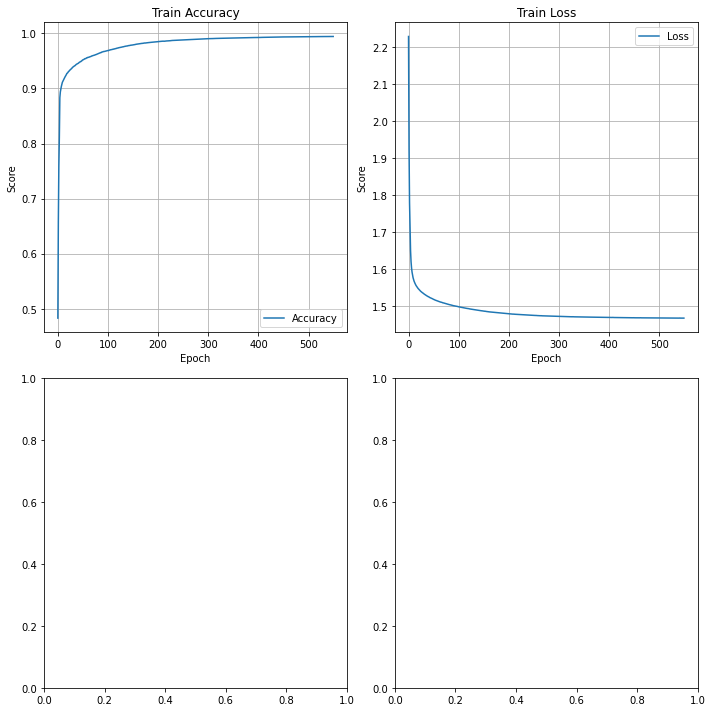

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10, 10))

ax[0][0].set_title("Train Accuracy")
ax[0][0].plot(train_metrics, label="Accuracy")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Score")
ax[0][0].grid()
ax[0][0].legend()

ax[0][1].set_title("Train Loss")
ax[0][1].plot(train_losses, label="Loss")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Score")
ax[0][1].grid()
ax[0][1].legend();

# ax[1][0].set_title("Train and Test Loss")
# ax[1][0].plot(train_losses, label="Train")
# ax[1][0].plot(test_losses, label="Test")
# ax[1][0].set_xlabel("Epoch")
# ax[1][0].set_ylabel("Score")
# ax[1][0].grid()
# ax[1][0].legend()

# ax[1][1].set_title("Train and Test Accuracy")
# ax[1][1].plot(train_metrics, label="Train")
# ax[1][1].plot(test_metrics, label="Test")
# ax[1][1].set_xlabel("Epoch")
# ax[1][1].set_ylabel("Score")
# ax[1][1].grid()
# ax[1][1].legend();

## X_train

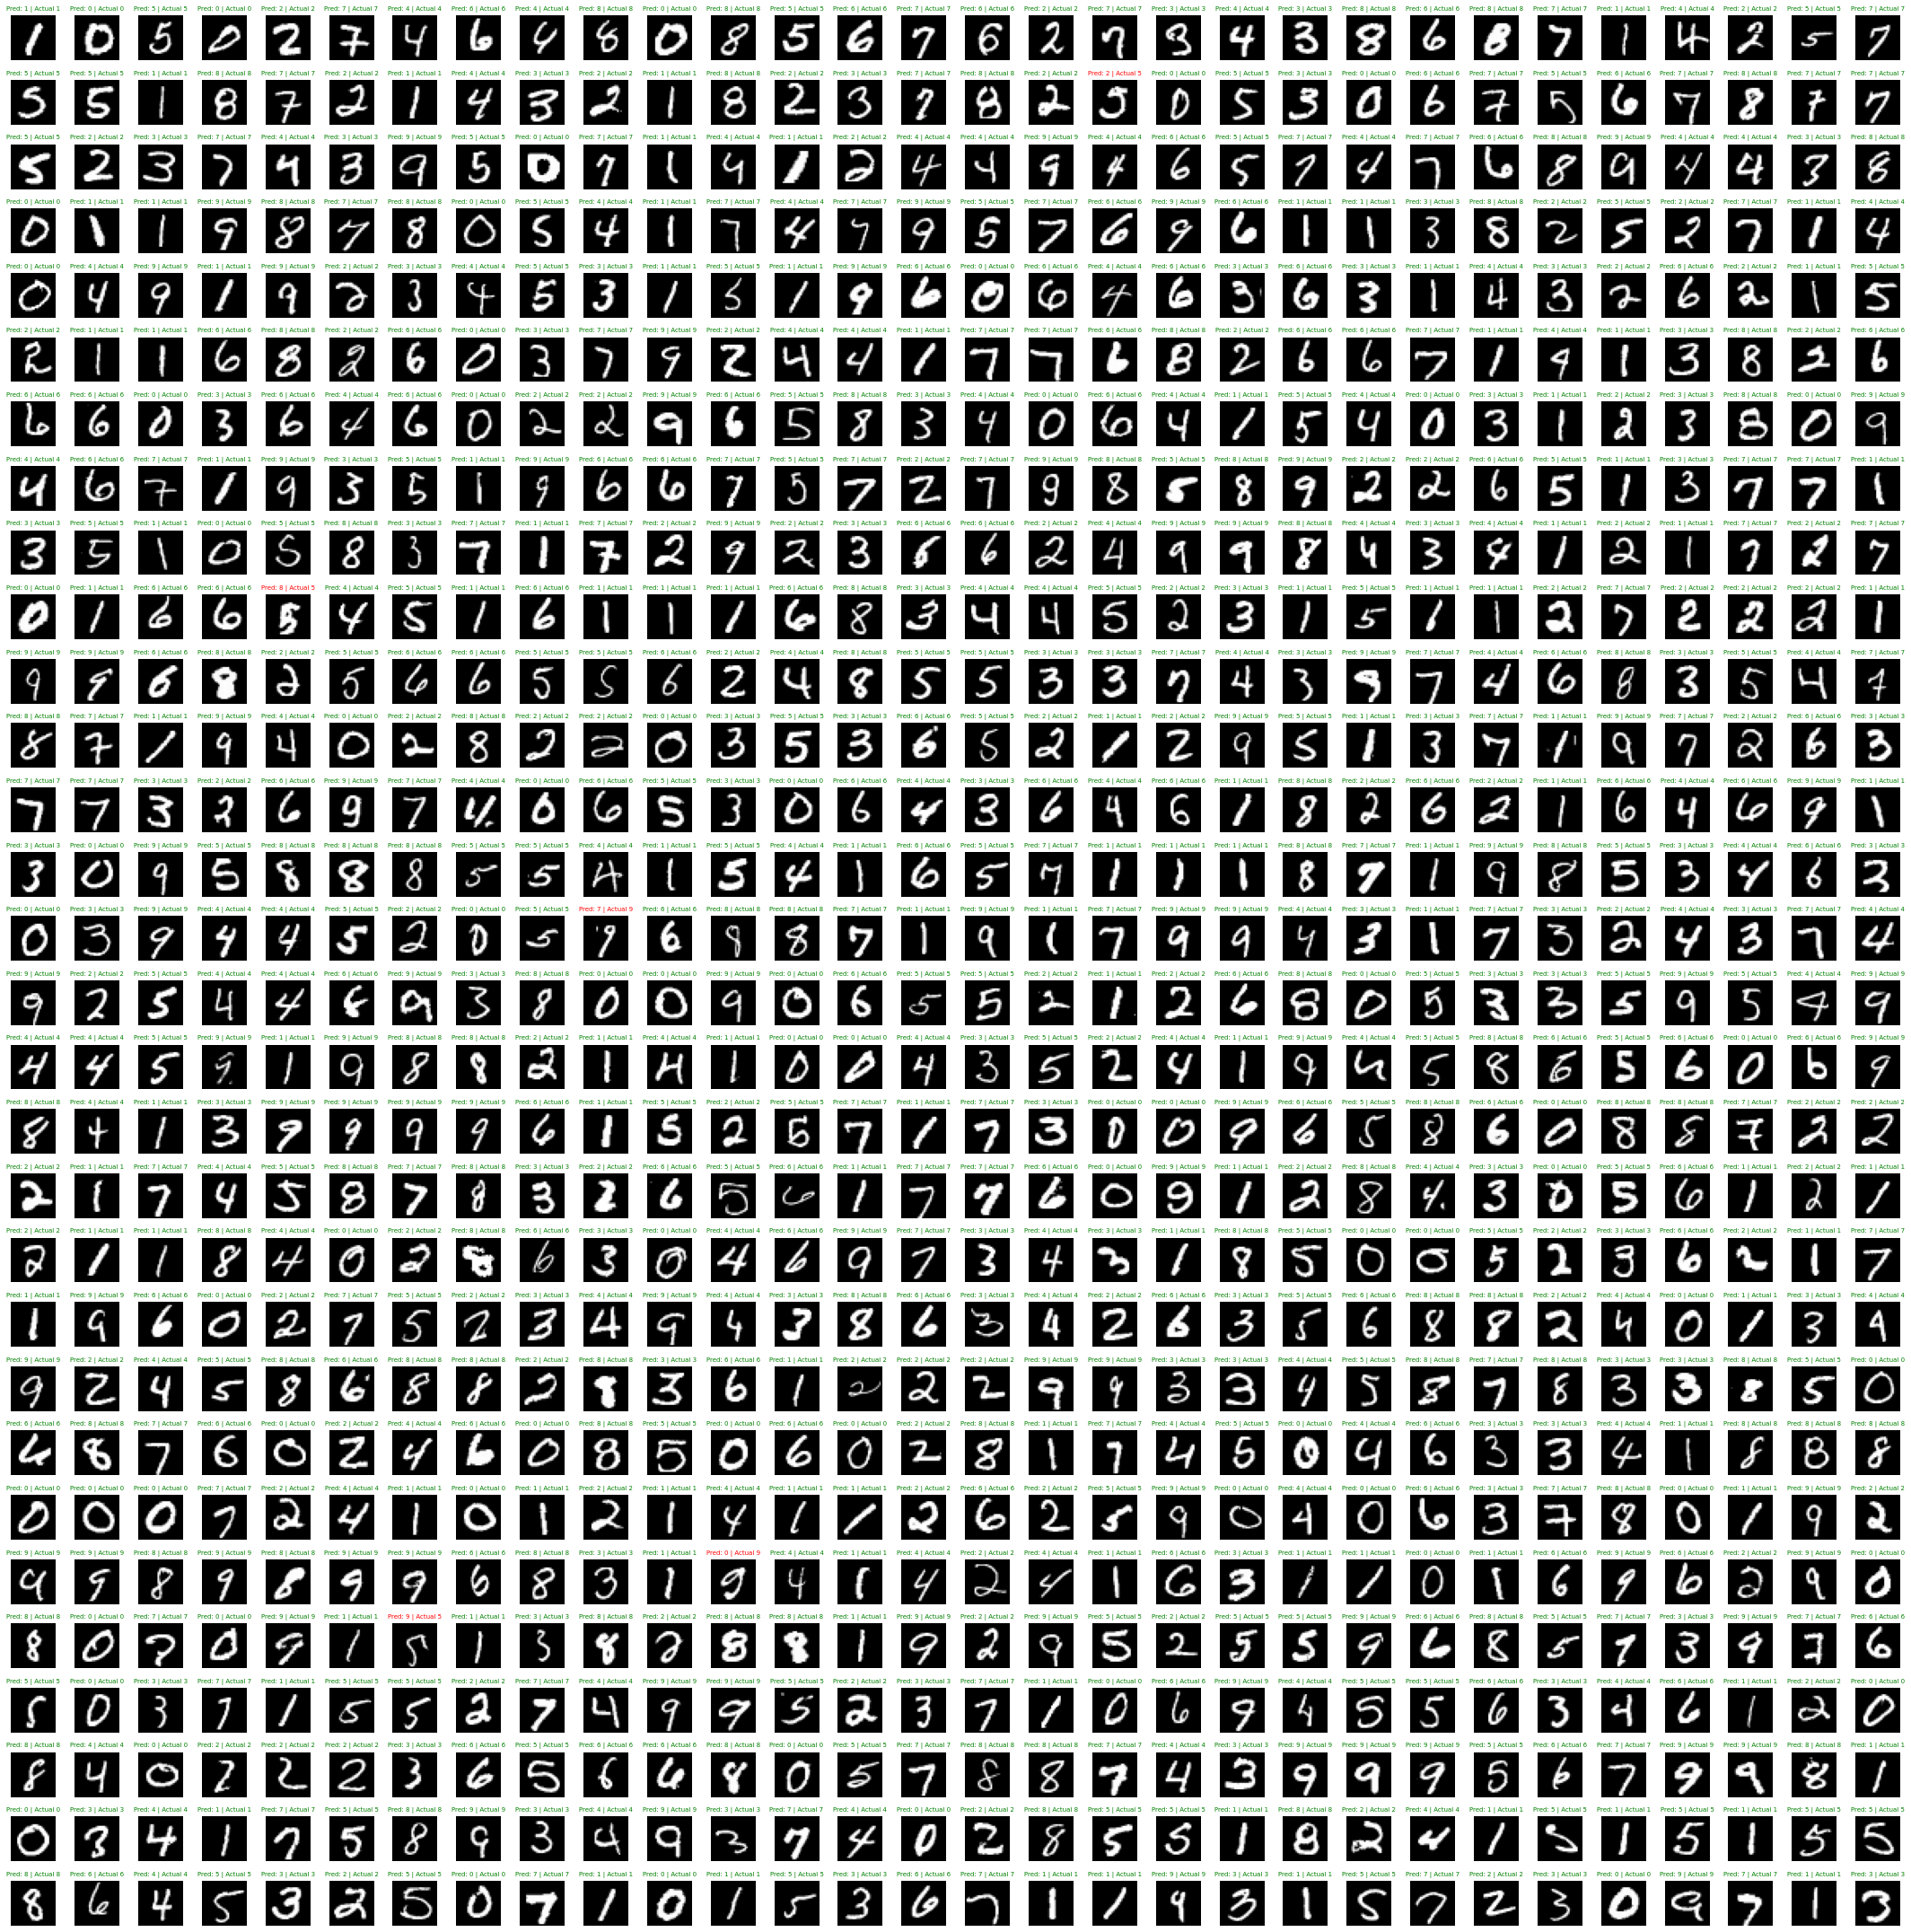

In [32]:
model.eval()
n_image = 900
idx_start = np.random.randint(0, len(X_test) - 1)
features = X_train[idx_start:idx_start+n_image]
actual_labels = y_train[idx_start:idx_start+n_image]
pred_labels = model(features).argmax(1)

plt.figure(figsize=(n_image**0.5, n_image**0.5), tight_layout=True)
for i in range(1, n_image + 1):
    plt.rcParams.update({"text.color": "green"} if pred_labels[i-1] == actual_labels[i-1] else {"text.color": "red"})
    plt.subplot(int(n_image**0.5), int(n_image**0.5), i)
    plt.title(f"Pred: {pred_labels[i-1]} | Actual {actual_labels[i-1]}", size=7)
    plt.imshow(features[i-1].reshape((28, 28)), cmap=plt.cm.gray)
    plt.axis("off")
plt.savefig("../callbacks/images/X_train_prediction.jpeg", dpi=100)

## X_test

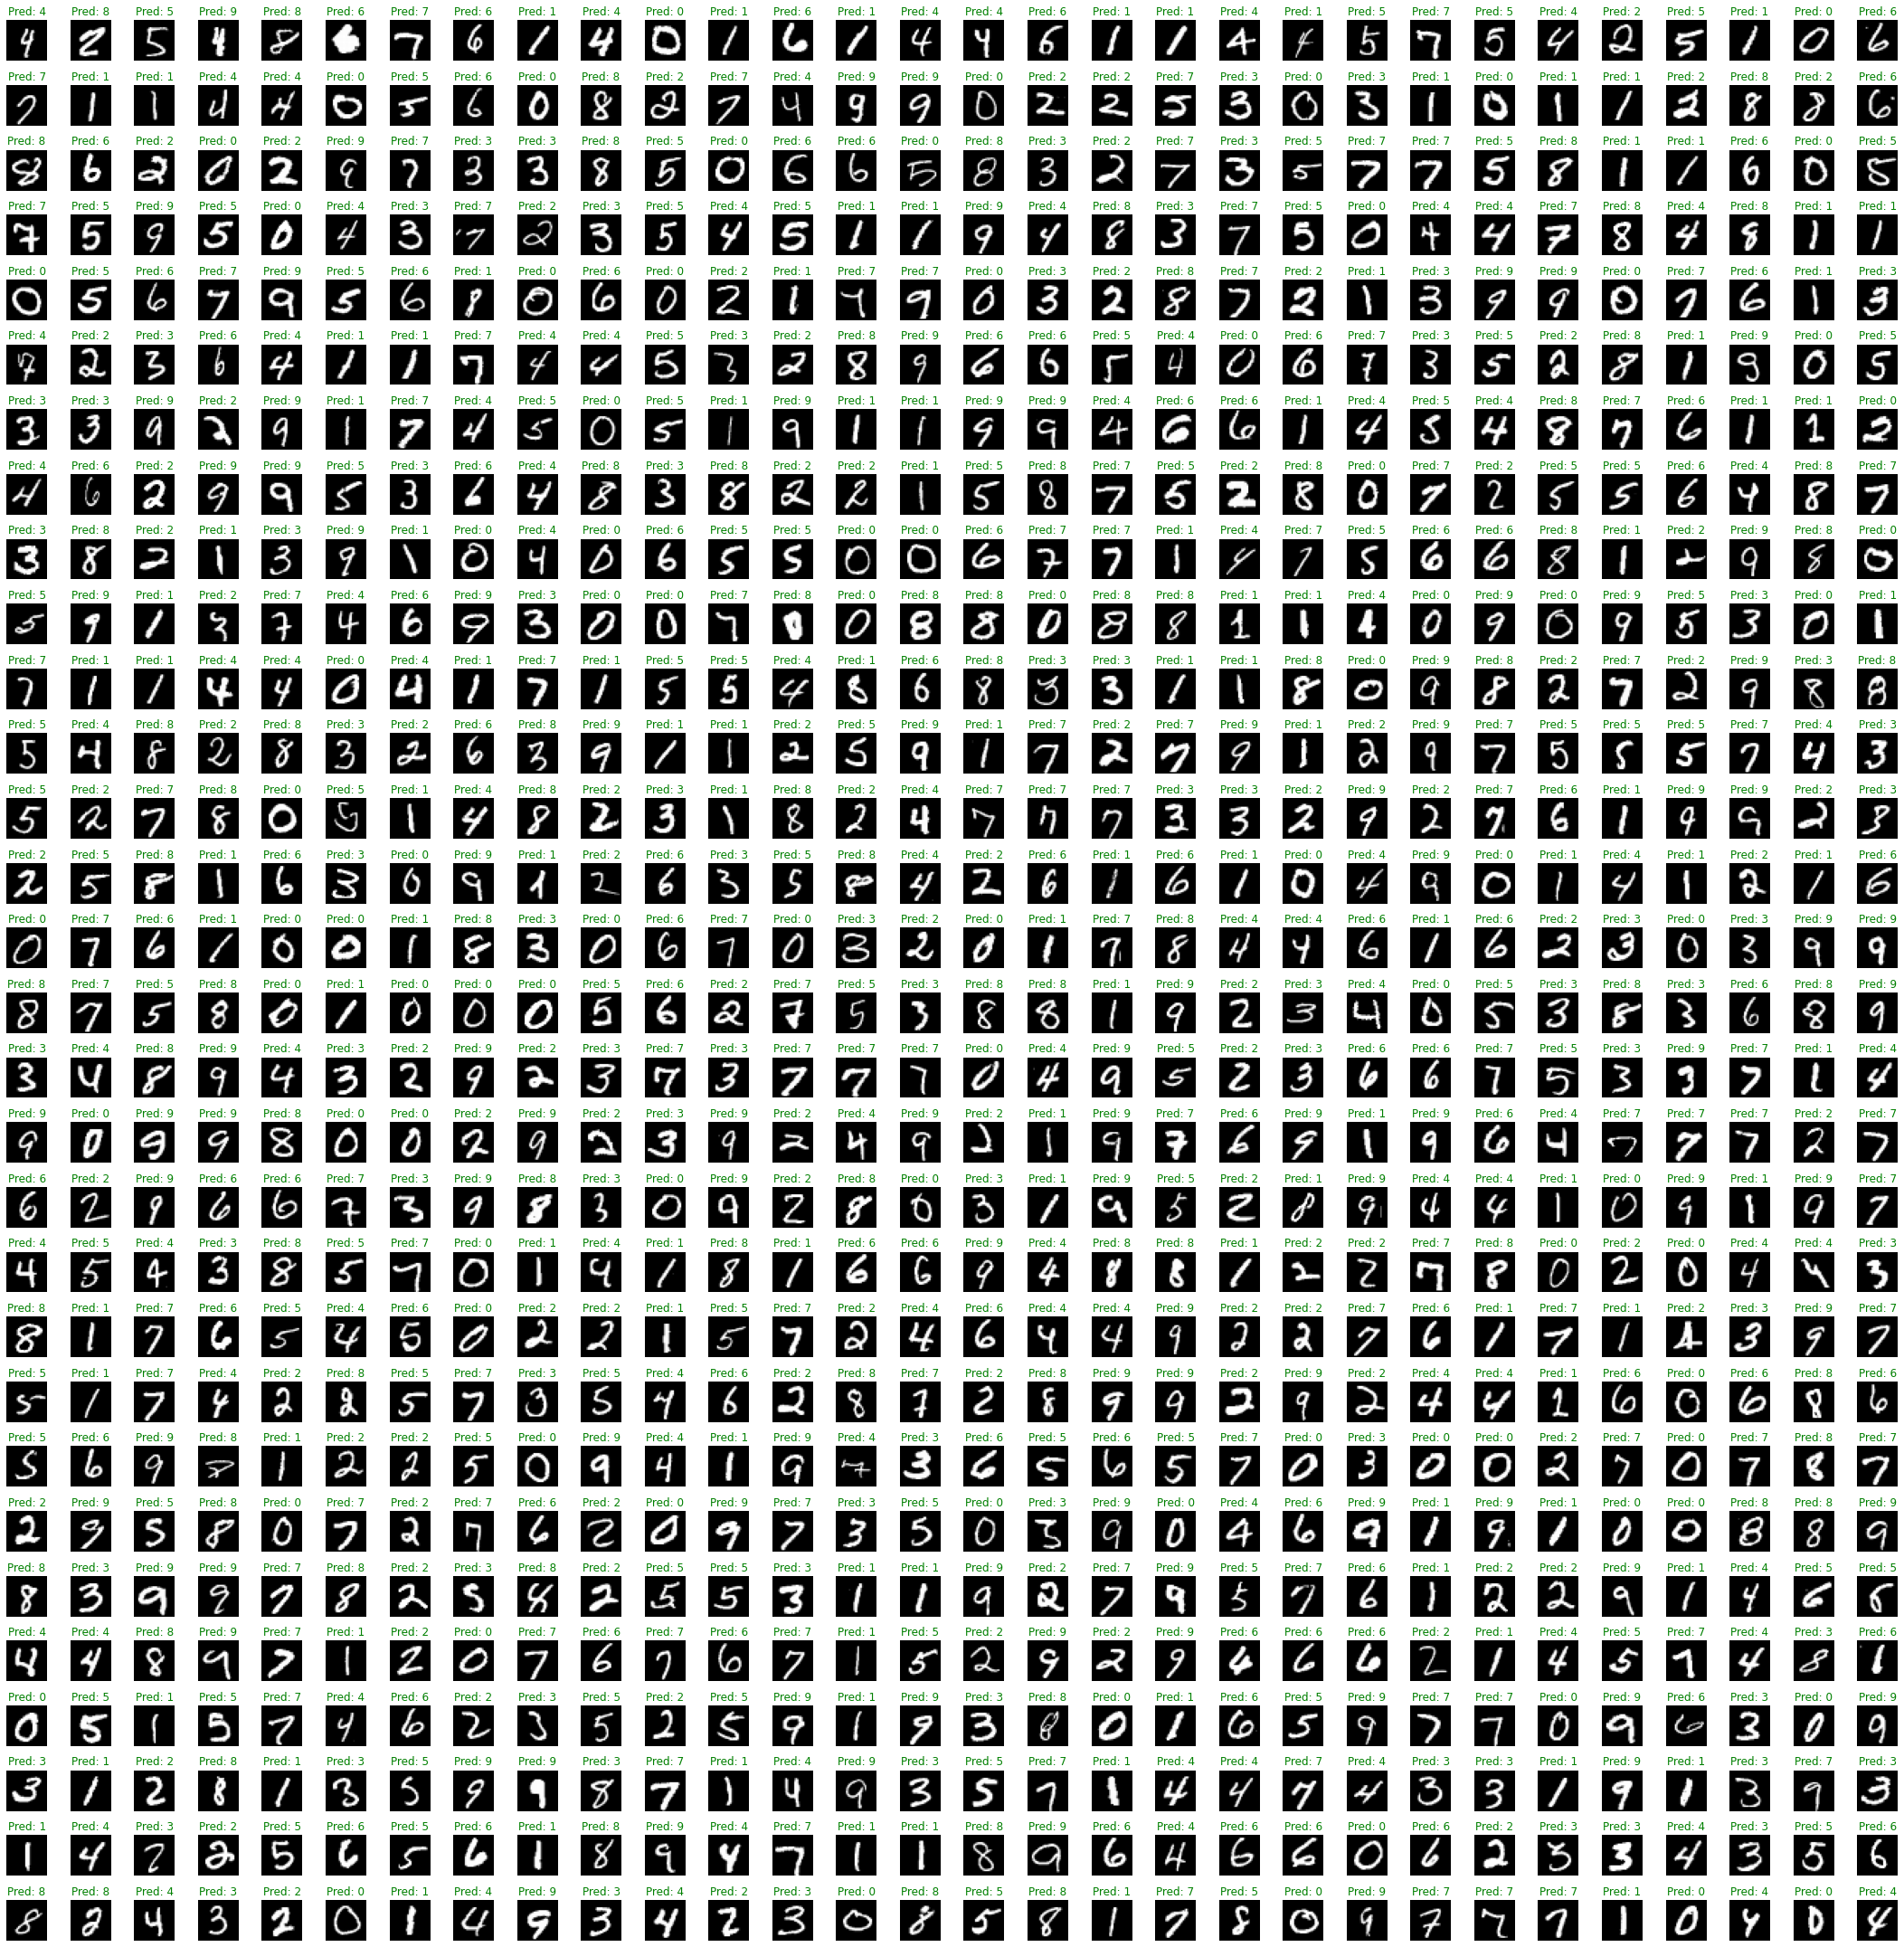

In [33]:
model.eval()
n_image = 900
idx_start = np.random.randint(0, len(X_test) - 1)
features = X_test[idx_start:idx_start+n_image]
pred_labels = model(features).argmax(1)

plt.figure(figsize=(n_image**0.5, n_image**0.5), tight_layout=True)
for i in range(1, n_image + 1):
    plt.subplot(int(n_image**0.5), int(n_image**0.5), i)
    plt.title(f"Pred: {pred_labels[i-1]}")
    plt.imshow(features[i-1].reshape((28, 28)), cmap=plt.cm.gray)
    plt.axis("off")
plt.savefig("../callbacks/images/X_test_prediction.jpeg", dpi=100)

# Predict

In [19]:
pred_labels = model(X_test).argmax(1)
submission_df = pd.DataFrame({
    "ImageId": np.arange(1, 28001),
    "Label": pred_labels
})

submission_df.to_csv(f"../submissions/{now}.csv", index=False)